In [ ]:
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from hmmlearn.hmm import GaussianHMM
from itertools import product

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_ta as ta
import warnings

warnings.filterwarnings('ignore')

: 

In [41]:
#Using parquet because massive dataset
df = pd.read_parquet("all_stock_data.parquet")
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,ED,0.000000,0.265828,0.261788,0.261788,25600.0,0.0,0.0
1,1962-01-02,CVX,0.000000,0.046809,0.046069,0.046809,105840.0,0.0,0.0
2,1962-01-02,GD,0.000000,0.210033,0.203061,0.208290,2648000.0,0.0,0.0
3,1962-01-02,BP,0.000000,0.141439,0.139528,0.139528,77440.0,0.0,0.0
4,1962-01-02,MSI,0.000000,0.764923,0.745254,0.751810,65671.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
34646253,2024-11-04,NEOG,14.490000,14.580000,14.340000,14.345000,18972.0,0.0,0.0
34646254,2024-11-04,ENLV,1.400000,1.428900,1.330000,1.350000,28794.0,0.0,0.0
34646255,2024-11-04,FAMI,0.320000,0.320000,0.300100,0.300100,77650.0,0.0,0.0
34646256,2024-11-04,NNN,43.730000,43.439999,43.209999,43.244999,88675.0,0.0,0.0


In [34]:
df['Volume'].median()

53800.0

In [ ]:
# Filter for recent rows only
cutoff = df["Date"].max() - timedelta(days=45)
df_recent = df[df["Date"] >= cutoff]

# Keep rows with valid Close and Volume only
df_recent = df_recent[(df_recent["Close"].notna()) & (df_recent["Volume"].notna())]

# Compute per-ticker stats (last close + avg volume)
summary = (
    df_recent.groupby("Ticker")
    .agg(LastPrice=('Close', 'last'), AvgVolume=('Volume', 'mean'))
)
# Filter by liquidity and price
filtered = summary.query("AvgVolume > 427_000 and LastPrice > 5")

# Get top 100 by average volume (faster than sort + head)
top_tickers = filtered.nlargest(100, "AvgVolume").index.tolist()

# Final filtered dataset
df_top100 = df[df["Ticker"].isin(top_tickers)]
df_top100

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
17,1962-01-02,BA,0.190311,0.190311,0.187037,0.187037,352350.0,0.0,0.0
23,1962-01-02,KO,0.004007,0.004116,0.004007,0.004007,806400.0,0.0,0.0
27,1962-01-02,XOM,0.000000,0.101537,0.100789,0.100789,902400.0,0.0,0.0
41,1962-01-03,BA,0.189843,0.193584,0.189843,0.190778,710775.0,0.0,0.0
42,1962-01-03,XOM,0.000000,0.102286,0.100789,0.102286,1200000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
34645932,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.0,0.0
34645942,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.0,0.0
34645985,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.0,0.0
34646132,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.0,0.0


In [43]:
df_top100 = df_top100.reset_index(drop=True)
df_top100

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,BA,0.190311,0.190311,0.187037,0.187037,352350.0,0.0,0.0
1,1962-01-02,KO,0.004007,0.004116,0.004007,0.004007,806400.0,0.0,0.0
2,1962-01-02,XOM,0.000000,0.101537,0.100789,0.100789,902400.0,0.0,0.0
3,1962-01-03,BA,0.189843,0.193584,0.189843,0.190778,710775.0,0.0,0.0
4,1962-01-03,XOM,0.000000,0.102286,0.100789,0.102286,1200000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
606027,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.0,0.0
606028,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.0,0.0
606029,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.0,0.0
606030,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.0,0.0


In [ ]:
def add_indicators(df):
    df = df.sort_values("Date") 
    df["rsi"] = ta.rsi(df["Close"], length=14)
    df["sma20"] = ta.sma(df["Close"], length=20)
    df["macd"] = ta.macd(df["Close"])["MACD_12_26_9"]
    df["atr"] = ta.atr(df["High"], df["Low"], df["Close"])
    return df

df_features = df_top100.groupby("Ticker", group_keys=False).apply(add_indicators).dropna(subset=["rsi", "sma20", "macd", "atr"]).reset_index(drop=True)
df_features 

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,rsi,sma20,macd,atr
0,1962-02-06,XOM,0.000000,0.110768,0.109271,0.109521,1446400.0,0.00000,0.0,75.646111,0.103284,0.003284,0.001415
1,1962-02-06,KO,0.003769,0.003769,0.003719,0.003719,691200.0,0.00000,0.0,45.517039,0.003728,-0.000058,0.000081
2,1962-02-06,BA,0.205256,0.205728,0.200066,0.205256,801900.0,0.00000,0.0,65.384446,0.198258,0.007225,0.004999
3,1962-02-07,BA,0.205256,0.209031,0.203841,0.205256,844425.0,0.00000,0.0,65.384446,0.199216,0.006874,0.005015
4,1962-02-07,XOM,0.000000,0.110479,0.108714,0.110479,1126400.0,0.01875,0.0,77.559897,0.103843,0.003396,0.001444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603515,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.00000,0.0,42.221555,26.387000,0.453875,1.199428
603516,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.00000,0.0,49.148475,33.970500,-0.192415,0.666130
603517,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.00000,0.0,44.584281,47.554500,-0.401666,1.241925
603518,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.00000,0.0,45.167088,6.199500,-0.098237,0.130932


In [55]:
features = df_features[["rsi", "sma20", "macd", "atr"]]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
df_features[["rsi_scaled", "sma20_scaled", "macd_scaled", "atr_scaled"]] = features_scaled
df_features

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,rsi,sma20,macd,atr,rsi_scaled,sma20_scaled,macd_scaled,atr_scaled
0,1962-02-06,XOM,0.000000,0.110768,0.109271,0.109521,1446400.0,0.00000,0.0,75.646111,0.103284,0.003284,0.001415,1.919453,-0.039017,0.014961,-0.037076
1,1962-02-06,KO,0.003769,0.003769,0.003719,0.003719,691200.0,0.00000,0.0,45.517039,0.003728,-0.000058,0.000081,-0.519479,-0.039029,0.014955,-0.037079
2,1962-02-06,BA,0.205256,0.205728,0.200066,0.205256,801900.0,0.00000,0.0,65.384446,0.198258,0.007225,0.004999,1.088777,-0.039005,0.014968,-0.037069
3,1962-02-07,BA,0.205256,0.209031,0.203841,0.205256,844425.0,0.00000,0.0,65.384446,0.199216,0.006874,0.005015,1.088777,-0.039005,0.014967,-0.037069
4,1962-02-07,XOM,0.000000,0.110479,0.108714,0.110479,1126400.0,0.01875,0.0,77.559897,0.103843,0.003396,0.001444,2.074373,-0.039017,0.014961,-0.037076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603515,2024-11-04,HOOD,23.750000,23.900000,23.540100,23.889999,1394526.0,0.00000,0.0,42.221555,26.387000,0.453875,1.199428,-0.786246,-0.035764,0.015732,-0.034647
603516,2024-11-04,CSX,33.470001,33.805000,33.369999,33.770000,680096.0,0.00000,0.0,49.148475,33.970500,-0.192415,0.666130,-0.225516,-0.034825,0.014626,-0.035728
603517,2024-11-04,FCX,45.599998,46.160000,45.626900,46.110001,487766.0,0.00000,0.0,44.584281,47.554500,-0.401666,1.241925,-0.594985,-0.033144,0.014268,-0.034561
603518,2024-11-04,ITUB,6.060000,6.165000,6.125000,6.160000,987570.0,0.00000,0.0,45.167088,6.199500,-0.098237,0.130932,-0.547807,-0.038262,0.014787,-0.036814


Model is not converging.  Current: 5092365.9233343685 is not greater than 5092365.924935157. Delta is -0.0016007889062166214
Model is not converging.  Current: 5092365.9233343685 is not greater than 5092365.924935157. Delta is -0.0016007889062166214
Model is not converging.  Current: 5000013.316447293 is not greater than 5000013.317398658. Delta is -0.0009513646364212036
Model is not converging.  Current: 5966346.223248857 is not greater than 5966582.986734005. Delta is -236.76348514761776
Model is not converging.  Current: 5966346.223248857 is not greater than 5966582.986734005. Delta is -236.76348514761776
Model is not converging.  Current: 5966346.223248857 is not greater than 5966582.986734005. Delta is -236.76348514761776
Model is not converging.  Current: 5815402.639663744 is not greater than 5815419.688925575. Delta is -17.04926183167845
Model is not converging.  Current: 5815402.639663744 is not greater than 5815419.688925575. Delta is -17.04926183167845
Model is not converging

Best Config (Based on BIC):
n_components                  6
cov_type                   full
tol                      0.0001
BIC            -12936381.193627
Name: 31, dtype: object


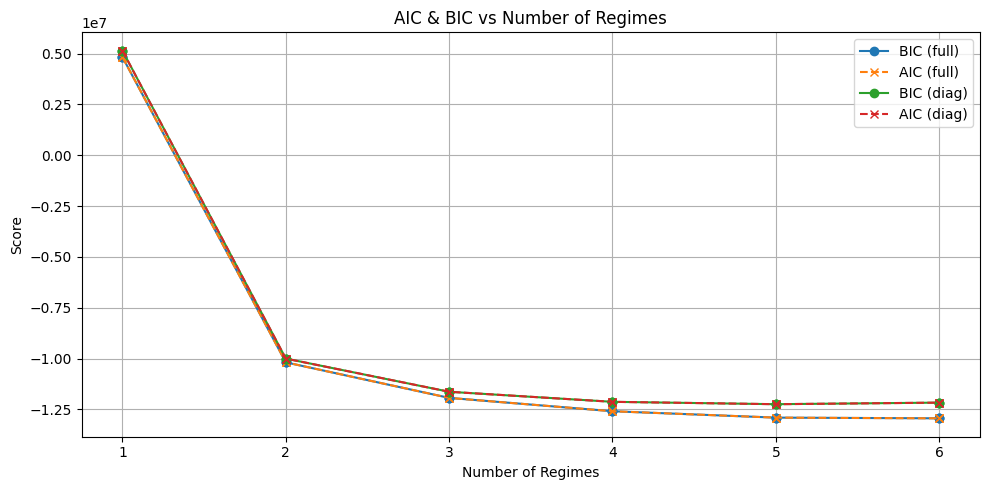

In [67]:
X = df_features[["rsi_scaled", "macd_scaled", "atr_scaled"]].dropna().values

# Define parameter search space
n_obs, n_features = X.shape
n_components_range = range(1, 7)  # Number of regimes to test
covariance_types = ['full', 'diag']  # Covariance matrix types
tolerances = [1e-2, 1e-4, 1e-6]  # Convergence tolerances

results = []

for n_components, cov_type, tol in product(n_components_range, covariance_types, tolerances):
    try:
        model = GaussianHMM(
            n_components=n_components,
            covariance_type=cov_type,
            tol=tol,
            n_iter=1000,
            random_state=42
        )
        model.fit(X)
        logL = model.score(X)

        # Estimate number of parameters
        k = n_components * (n_components - 1)  # transition probs
        k += n_components - 1                 # initial probs
        k += n_components * n_features * 2    # means and variances

        bic = -2 * logL + k * np.log(n_obs)
        aic = -2 * logL + 2 * k

        results.append({
            'n_components': n_components,
            'cov_type': cov_type,
            'tol': tol,
            'log_likelihood': logL,
            'AIC': aic,
            'BIC': bic
        })
    except Exception as e:
        results.append({
            'n_components': n_components,
            'cov_type': cov_type,
            'tol': tol,
            'log_likelihood': None,
            'AIC': np.inf,
            'BIC': np.inf,
            'error': str(e)
        })

# Convert to DataFrame and find best config
df_results = pd.DataFrame(results)
best_model = df_results.loc[df_results['BIC'].idxmin()]
print("Best Config (Based on BIC):")
print(best_model[["n_components", "cov_type", "tol", "BIC"]])

# Visualize BIC and AIC
plt.figure(figsize=(10, 5))
for cov in covariance_types:
    subset = df_results[df_results["cov_type"] == cov]
    plt.plot(subset["n_components"], subset["BIC"], label=f"BIC ({cov})", marker="o")
    plt.plot(subset["n_components"], subset["AIC"], label=f"AIC ({cov})", linestyle="--", marker="x")

plt.title("AIC & BIC vs Number of Regimes")
plt.xlabel("Number of Regimes")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
X

NameError: name 'X' is not defined

In [68]:
best_model

n_components                    6
cov_type                     full
tol                        0.0001
log_likelihood     6468663.120787
AIC              -12937184.241574
BIC              -12936381.193627
Name: 31, dtype: object

Model is not converging.  Current: 6468665.583055108 is not greater than 6468666.626687538. Delta is -1.043632430024445


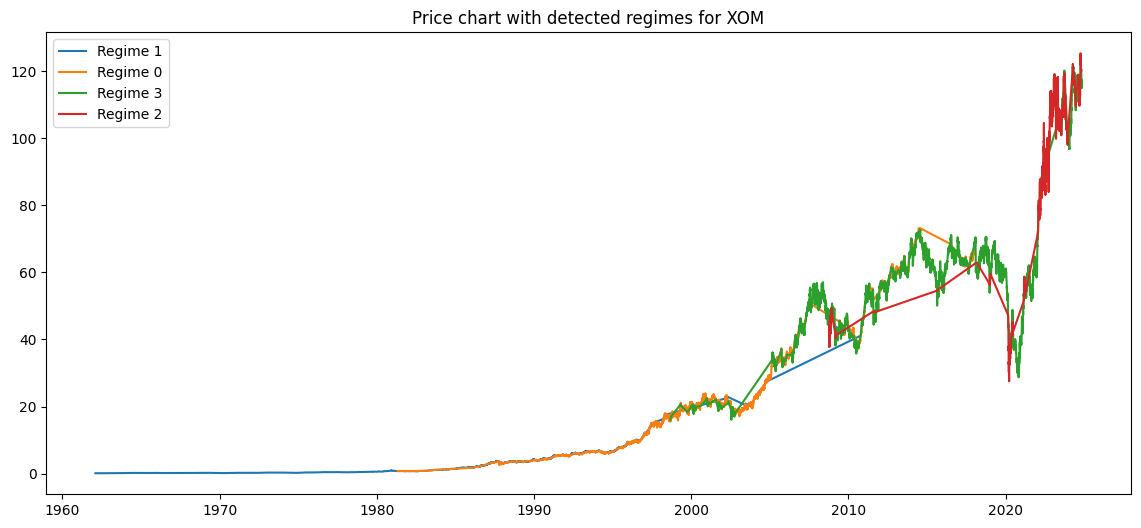

In [69]:
best_params = best_model

model = GaussianHMM(
    n_components=int(best_params['n_components']),
    covariance_type=best_params['cov_type'],
    tol=best_params['tol'],
    n_iter=1000,
    random_state=42
)
model.fit(X)

# Predict the hidden regime for each row
hidden_states = model.predict(X)

df_regime = df_features.dropna(subset=["rsi_scaled", "macd_scaled", "atr_scaled"]).copy()
df_regime["regime"] = hidden_states

sample_ticker = df_regime["Ticker"].iloc[0]  # use any ticker
sample_df = df_regime[df_regime["Ticker"] == sample_ticker]

plt.figure(figsize=(14, 6))
for state in sample_df["regime"].unique():
    subset = sample_df[sample_df["regime"] == state]
    plt.plot(subset["Date"], subset["Close"], label=f"Regime {state}")
plt.legend()
plt.title(f"Price chart with detected regimes for {sample_ticker}")
plt.show()

In [ ]:
# 1. Calculate forward returns (e.g., 5-day return)
df_regime["future_return"] = df_regime.groupby("Ticker")["Close"].shift(-5) / df_regime["Close"] - 1

# 2. Get average future return per regime
regime_returns = df_regime.groupby("regime")["future_return"].mean().sort_values(ascending=False)

# 3. Map each regime to a signal
# Highest return → Buy, Lowest return → Sell, others → Hold
regime_signal_map = {}

# Assign Buy to top regime
regime_signal_map[regime_returns.index[0]] = "Buy"

# Assign Sell to worst regime
regime_signal_map[regime_returns.index[-1]] = "Sell"

# Assign Hold to all others
for regime in regime_returns.index[1:-1]:
    regime_signal_map[regime] = "Hold"

# 4. Map the signal back to the main DataFrame
df_regime["signal"] = df_regime["regime"].map(regime_signal_map)

In [ ]:
import matplotlib.dates as mdates

# Prepare data
sample_ticker = df_regime["Ticker"].iloc[0]
sample_df = df_regime[df_regime["Ticker"] == sample_ticker].copy()

# Optional: get posterior probabilities (confidence in predicted regime)
# Assuming `model` is your fitted GaussianHMM
X_sample = sample_df[["Close", "Volume"]]  # use your actual features
sample_df["posterior"] = model.predict_proba(X_sample).max(axis=1)

# Plot setup
fig, ax = plt.subplots(figsize=(14, 6))

# Plot price
ax.plot(sample_df["Date"], sample_df["Close"], label="Close Price", color="black", alpha=0.7)

# Plot Buy/Sell/Hold markers
buy = sample_df[sample_df["signal"] == "Buy"]
sell = sample_df[sample_df["signal"] == "Sell"]
hold = sample_df[sample_df["signal"] == "Hold"]

ax.scatter(buy["Date"], buy["Close"], color="green", label="Buy", marker="^", s=100)
ax.scatter(sell["Date"], sell["Close"], color="red", label="Sell", marker="v", s=100)
ax.scatter(hold["Date"], hold["Close"], color="orange", label="Hold", marker=".", s=50)

# Plot regime background shading
prev_regime = None
start_date = None
for i in range(len(sample_df)):
    curr_regime = sample_df["regime"].iloc[i]
    curr_date = sample_df["Date"].iloc[i]
    if prev_regime is None:
        prev_regime = curr_regime
        start_date = curr_date
    elif curr_regime != prev_regime:
        end_date = curr_date
        ax.axvspan(start_date, end_date, alpha=0.1, color=f"C{prev_regime}")
        prev_regime = curr_regime
        start_date = curr_date
# Add final span
ax.axvspan(start_date, sample_df["Date"].iloc[-1], alpha=0.1, color=f"C{prev_regime}")

# Add posterior probability as confidence line
ax2 = ax.twinx()
ax2.plot(sample_df["Date"], sample_df["posterior"], color="blue", alpha=0.3, label="Confidence")
ax2.set_ylabel("Model Confidence (max posterior prob)", color="blue")
ax2.tick_params(axis='y', labelcolor='blue')

# Final touches
ax.set_title(f"Trading Signals and Regimes for {sample_ticker}")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.legend(loc="upper left")
ax.grid(True)
fig.tight_layout()
plt.show()